In [1]:
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
from os.path import abspath, dirname, expanduser, expandvars
import sys

import numpy as np

os.sys.path.append(expanduser('~/src/retro')) #dirname(dirname(abspath(__file__))))
from retro import Event, HypoParams8D
from retro import (event_to_hypo_params, extract_photon_info,
                   powerspace, spherical_volume)
from retro.discrete_hypo import DiscreteHypo, const_energy_loss_muon, point_cascade
from retro.events import Events
from retro.likelihood import get_neg_llh, scan
from retro.table_readers import DOMTimePolarTables, TDICartTables

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

[ WARNING] /home/justin/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)



PISA running in double precision (FP64) mode.


In [4]:
dom_tables = DOMTimePolarTables(
    tables_dir='/fastio/icecube/retro_tables/full1000',
    hash_val=None,
    geom=np.load(expanduser('/home/justin/src/retro/retro/data/geo_array.npy')),
    use_directionality=False,
)

In [10]:
%%time
dom_tables.load_tables()

CPU times: user 3.82 s, sys: 620 ms, total: 4.44 s
Wall time: 4.44 s


In [13]:
print len(dom_tables.tables['dc'])
tbl = dom_tables.tables['ic'][0]
tbl.survival_prob[-1].sum()

60


0.31799731

In [14]:
cascade_hypo = DiscreteHypo(hypo_kernels=[point_cascade])

In [15]:
hypo_params = HypoParams8D(
    t=10, x=-10, y=100, z=-100,
    track_azimuth=0, track_zenith=0, track_energy=0,
    cascade_energy=1
)

In [16]:
cascade_hypo.get_sources(hypo_params)

array([[  1.00000000e+01,  -1.00000000e+01,   1.00000000e+02,
         -1.00000000e+02,   1.28053379e+04,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]], dtype=float32)

In [17]:
track_hypo = DiscreteHypo(hypo_kernels=[const_energy_loss_muon])

In [18]:
hypo_params = HypoParams8D(
    t=0, x=0, y=0, z=0,
    track_azimuth=0, track_zenith=0, track_energy=1,
    cascade_energy=0
)

In [19]:
len(track_hypo.get_sources(hypo_params))

15

In [20]:
events = Events('/fastio/icecube/deepcore/data/MSU_sample/level5pt/numu/14600//icetray_hdf5/Level5pt_IC86.2013_genie_numu.014600.000000.hdf5')

Loading events from path "/fastio/icecube/deepcore/data/MSU_sample/level5pt/numu/14600//icetray_hdf5/Level5pt_IC86.2013_genie_numu.014600.000000.hdf5"


"true" hypo params:
HypoParams8D(t=9824.4764170572234, x=29.105741382858099, y=-57.676409950422851, z=-264.21308204838323, track_zenith=1.9231773221690973, track_azimuth=0.92129931620212169, track_energy=2.8971111826800402, cascade_energy=0.4191339238395187)
modified hypo params:
 HypoParams8D(t=9824.4764170572234, x=29.105741382858099, y=-57.676409950422851, z=-264.21308204838323, track_zenith=1.2184153314206958, track_azimuth=5.3618859909774645, track_energy=2.8971111826800402, cascade_energy=41.913392383951873)
[ WARNING] /home/justin/src/retro/retro/discrete_hypo.py:113: RuntimeWarning: overflow encountered in double_scalars
  sources[0, 4] = EM_CASCADE_PHOTONS_PER_GEV * hypo_params.cascade_energy

[ WARNING] /home/justin/.local/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in double_scalars



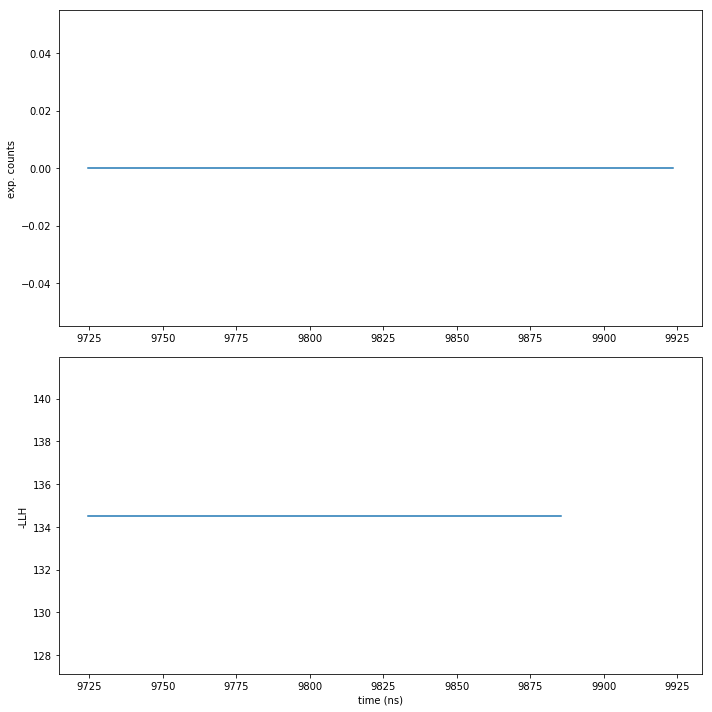

In [22]:
full_hypo = DiscreteHypo(hypo_kernels=[const_energy_loss_muon, point_cascade])

event = events[0]

hypo_params = event_to_hypo_params(event)
print '"true" hypo params:\n%s' % (hypo_params,)
hypo_params = HypoParams8D(
    t=hypo_params.t, x=hypo_params.x, y=hypo_params.y, z=hypo_params.z,
    track_azimuth=2*np.pi-hypo_params.track_azimuth,
    track_zenith=np.pi-hypo_params.track_zenith,
    track_energy=1*hypo_params.track_energy,
    cascade_energy=100*hypo_params.cascade_energy,
)
print 'modified hypo params:\n %s' % (hypo_params,)

hit_string = event.pulses.strings[0]
hit_om = event.pulses.oms[0]

time_samples = np.arange(hypo_params.t-100, hypo_params.t+100, 1)
expected_counts = []
neg_llh = []
for time_sample in time_samples:
    #hypo_params = HypoParams8D(
    #    t=t, x=47, y=-37, z=-370,
    #    track_azimuth=0, track_zenith=np.pi, track_energy=10,
    #    cascade_energy=0
    #)
    sources = full_hypo.get_sources(hypo_params)
    if time_sample == hypo_params.t:
        print 'sources:', sources[0, :]
        
    hypo_params = HypoParams8D(
        t=time_sample, x=hypo_params.x, y=hypo_params.y, z=hypo_params.z,
        track_azimuth=2*np.pi-hypo_params.track_azimuth,
        track_zenith=np.pi-hypo_params.track_zenith,
        track_energy=1*hypo_params.track_energy,
        cascade_energy=1e6*hypo_params.cascade_energy,
    )
    
    expected_counts.append(
        dom_tables.get_photon_expectation(
            sources=sources,
            hit_time=event.pulses.times[0],
            string=hit_string,
            depth_idx=hit_om,
            use_directionality=False
        )
    )
    neg_llh.append(
        get_neg_llh(sources,
                    event=event,
                    dom_tables=dom_tables,
                    tdi_table=None)
    )
expected_counts = np.array(expected_counts)
neg_llh = np.array(neg_llh)


fig = plt.figure(1, figsize=(10,10))
fig.clf()
ax1 = fig.add_subplot(211)
ax1.plot(time_samples, expected_counts)
ax2 = fig.add_subplot(212, sharex=ax1)
ax2.plot(time_samples, neg_llh)
ax1.set_ylabel('exp. counts')
#ax1.set_title('Expected detected counts for hypo in one DOM')
ax2.set_xlabel('time (ns)')
ax2.set_ylabel('-LLH')
#ax2.set_title('-LLH')
fig.tight_layout()
pass

In [136]:
event.pulses.oms

array([19, 19, 23, 24, 25, 25, 25, 25, 20, 26, 23], dtype=uint32)

In [6]:
survival_prob = dom_tables.tables['dc'][50].survival_prob
print 'product', (1 - (1 - survival_prob).prod(axis=0)).max()
print 'sum', survival_prob.sum(axis=0).max()

product 0.00806636
sum 0.00809809


In [7]:
print '1 - (1-P(a))*(1-P(b))  %0.12e' % (1 - (1 - survival_prob).prod())
r_edges = powerspace(0, 400, 201, power=2)
costheta_edges = np.linspace(-1, 1, 41)
dphi = 1
R_EDGES, COSTHETA_EDGES = np.meshgrid(r_edges, costheta_edges, indexing='ij')
vols = spherical_volume(
    rmin=R_EDGES[:-1, :-1], rmax=R_EDGES[1:, 1:],
    dcostheta=COSTHETA_EDGES[1:, 1:] - COSTHETA_EDGES[:-1, :-1],
    dphi=dphi
)
#print 'simple average         %0.12e' % np.average(survival_prob.mean(axis=0))
print 't bins mutually exclusive             : %0.12e' % np.average(survival_prob.mean(axis=0), weights=vols)
print 't bins not mutually excl but are indep: %0.12e' % np.average(1 - (1 - survival_prob).prod(axis=0), weights=vols)

1 - (1-P(a))*(1-P(b))  9.999999867528e-01
t bins mutually exclusive             : 1.881157472273e-06
t bins not mutually excl but are indep: 5.636281083869e-04


In [8]:
t_indep = 1 - (1 - survival_prob).prod(axis=0)
print 'vol-weighted avg       %0.12e' % np.average(1 - (1 - survival_prob).prod(axis=0), weights=vols)


vol-weighted avg       5.636281083869e-04


In [9]:
print '1 - (1-P(a))*(1-P(b))  %0.12e' % (1 - (1 - survival_prob).prod())
r_edges = powerspace(0, 400, 201, power=2)
costheta_edges = np.linspace(-1, 1, 41)
dphi = 1
R_EDGES, COSTHETA_EDGES = np.meshgrid(r_edges, costheta_edges, indexing='ij')
vols = spherical_volume(
    rmin=R_EDGES[:-1, :-1], rmax=R_EDGES[1:, 1:],
    dcostheta=COSTHETA_EDGES[1:, 1:] - COSTHETA_EDGES[:-1, :-1],
    dphi=dphi
)
print 'simple average         %0.12e' % np.average(survival_prob.mean(axis=0))
print 'vol-weighted avg       %0.12e' % np.average(survival_prob.mean(axis=0), weights=vols)

1 - (1-P(a))*(1-P(b))  9.999999867528e-01
simple average         7.555087904620e-06
vol-weighted avg       1.881157472273e-06


In [55]:
%%time
one_minus_sp = np.zeros_like(dom_tables.tables['ic'][0].survival_prob)
for subdet in ['ic', 'dc']:
    for depth_idx in range(60):
        if subdet == 'ic':
            nstr = 79
        else:
            nstr = 7
        for string in range(nstr):
            one_minus_sp += np.sum(np.log(1 - dom_tables.tables[subdet][depth_idx].survival_prob), axis=0)
#np.sum(tbl.survival_prob == 1)

CPU times: user 1min 39s, sys: 0 ns, total: 1min 39s
Wall time: 1min 39s


In [59]:
np.sum((1 - np.exp(one_minus_sp)) == 1) / np.prod(one_minus_sp.shape)

0.17150000000000001

In [10]:
%%time
trange = range(-3000, 0, 10)
sources = np.array(
    [[t, 47, -37, -370, 1, 0.5, 0.5, 0.5] for t in trange],
    dtype=np.float64
)
starting_counts = np.sum(sources[:, 4])
expected_counts = dom_tables.get_photon_expectation(sources, 36, 50)
print 'starting_counts:', starting_counts
print 'p_det:', expected_counts/starting_counts
print 'expected_counts:', expected_counts

<type 'numpy.ndarray'> (300, 200, 40) float32
starting_counts: 300.0
p_det: 1.01171151825e-05
expected_counts: 0.00303513455475
CPU times: user 332 ms, sys: 8 ms, total: 340 ms
Wall time: 1.02 s


In [31]:
pinfo, bin_edges = extract_photon_info(
    '/fastio/icecube/retro_tables/full1000/retro_nevts1000_DC_DOM0_r_cz_t_angles.fits',
    depth_idx=0,
    scale=1
)

In [89]:
%%time

one_minus_p_det = 1
#col = 0
all_counts = []
for depth_idx in range(0, 60):
    #sys.stdout.write('-'*20 + 'depth_idx = %d\n' % depth_idx)
    for string in range(1, 87):
        str_counts = []
        for t in range(-3000, 0, 10):
            pinfo = np.array([[t, 47, -37, -370, 1, 0.5, 0.5, 0.5]])
            prob = dom_tables.get_photon_expectation(sources, string, depth_idx)
            str_counts.append(prob)
        all_counts.append(str_counts)
#        one_minus_p_det *= 1 - counts/starting_counts
#        #sys.stdout.write('%.0e ' % counts)
#        #col += 1
#        #if col % 20 == 0:
#        #    sys.stdout.write('\n')
#    #sys.stdout.write('\n')
#    #col = 0
#p_det = 1 - one_minus_p_det
#all_dom_expected_counts = starting_counts * p_det
#print 'p_det:', p_det
#print 'all_dom_expected_counts:', all_dom_expected_counts

CPU times: user 27min 55s, sys: 1min 2s, total: 28min 57s
Wall time: 27min 49s


In [90]:
all_counts = np.array(all_counts)
all_counts.shape

(5160, 300)

In [103]:
probs_with_log = np.log((1 - all_counts)).sum()
probs_with_prod = (1 - all_counts).prod()
print 'log:', np.exp(probs_with_log)
print 'prod:', probs_with_prod

log: 5.48212774772e-69
prod: 5.48212774772e-69


In [42]:
tdi = TDICartTables(
    tables_dir='/fastio/icecube/retro_tables/full1000',
    use_directionality=True,
    proto_tile_hash='0e28683a74ebea92', # 14^3 tiles, 1 m gridsize, +/- 700 m in x and y, -800 to +600 in z
    #proto_tile_hash='8c4770c8371a4025', # single tile, 10 m gridsize +/- 700 m in x and y, -800 to +600 in z
    scale=1,
)

Loaded 2744 tiles spanning x ∈ [-700.00, 700.00) m, y ∈ [-700.00, 700.00) m, z ∈ [-800.00, 600.00) m; bins are (1.000 m)³
Time to load: 01:10.768


In [161]:
print 'pct>1.0:', 100 * np.sum(tdi.survival_prob > 1) / tdi.n_bins
print 'pct 1.0:', 100 * np.sum(tdi.survival_prob == 1) / tdi.n_bins
print 'pct 0.0:', 100 * np.sum(tdi.survival_prob == 0) / tdi.n_bins
print 'pct nan:', 100 * np.sum(np.isnan(tdi.survival_prob)) / tdi.n_bins
print 'pct nan:', 100 * np.sum(np.isnan(tdi.avg_photon_x)) / tdi.n_bins
print 'pct nan:', 100 * np.sum(np.isnan(tdi.avg_photon_y)) / tdi.n_bins
print 'pct nan:', 100 * np.sum(np.isnan(tdi.avg_photon_z)) / tdi.n_bins
print tdi.nx_tiles, tdi.ny_tiles, tdi.nz_tiles, tdi.n_tiles
print tdi.nx, tdi.ny, tdi.nz, tdi.n_bins
#print tdi.tables_meta

pct>1.0: 0.0
pct 1.0: 0.0
pct 0.0: 0.697520444606
pct nan: 0.0
pct nan: 0.0
pct nan: 0.0
pct nan: 0.0
14 14 14 2744
1400 1400 1400 2744000000


In [164]:
%%time

print 'surv prob:', tdi.get_photon_expectation(sources) / sources[:, 4].sum()

surv prob: 0.876397192478
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 677 µs


In [47]:
%time
depths = range(10)
strings = range(10)
hit_probs = []
for hit_string, hit_depth in zip(depths, strings): 
    hit_probs.append(dom_tables.get_photon_expectation(sources, hit_string, hit_depth))
nohit = tdi.get_photon_expectation(sources)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [46]:
hit_probs

[0.003035134554747465,
 0.003035134554747465,
 0.003035134554747465,
 0.003035134554747465,
 0.003035134554747465,
 0.003035134554747465,
 0.003035134554747465,
 0.003035134554747465,
 0.003035134554747465,
 0.003035134554747465]

In [30]:
TDICartTables.get_table_metadata('/fastio/icecube/retro_tables/full1000/retro_tdi_table_5282011d66756b9e_binmap_14cdb70cd8dd54eb_geom_e8edd31b1cb7514c_domtbl_none_times_all_x-500.000_500.000_y-500.000_500.000_z-500.000_500.000_bw10.000000000_anisot_none_survival_prob.fits')

{'anisotropy': None,
 'binmap_hash': '14cdb70cd8dd54eb',
 'binwidth': 10.0,
 'dom_tables_hash': None,
 'geom_hash': 'e8edd31b1cb7514c',
 'table_name': 'survival_prob',
 'tdi_hash': '5282011d66756b9e',
 'time_indices': slice(None, None, None),
 'times_str': 'all',
 'x_max': 500.0,
 'x_min': -500.0,
 'x_width': 1000.0,
 'y_max': 500.0,
 'y_min': -500.0,
 'y_width': 1000.0,
 'z_max': 500.0,
 'z_min': -500.0,
 'z_width': 1000.0}

In [78]:
np.sum(tdi.survival_prob > 0) / tdi.n_bins

0.99251712827988336

In [10]:
x_os_bw = x_bw / x_oversample
y_os_bw = y_bw / y_oversample
z_os_bw = z_bw / z_oversample

dom_x, dom_y, dom_z = all_doms[0, 0]
dom_x_fract_os_idx = (dom_x - xlims[0]) / x_os_bw
dom_y_fract_os_idx = (dom_y - ylims[0]) / y_os_bw
dom_z_fract_os_idx = (dom_z - zlims[0]) / z_os_bw

dom_x_os_idx = int(round(dom_x_fract_os_idx))
dom_y_os_idx = int(round(dom_y_fract_os_idx))
dom_z_os_idx = int(round(dom_z_fract_os_idx))

dom_x_idx = int(dom_x_os_idx // x_oversample)
dom_y_idx = int(dom_y_os_idx // y_oversample)
dom_z_idx = int(dom_z_os_idx // z_oversample)

print(dom_x, dom_y, dom_z)
print(dom_x_fract_os_idx, dom_y_fract_os_idx, dom_z_fract_os_idx)
print(dom_x_os_idx, dom_y_os_idx, dom_z_os_idx)
print(dom_x_idx, dom_y_idx, dom_z_idx)

(46.290000915527344, -34.880001068115234, -316.01998901367188)
(283.88700027465819, 259.53599967956541, 130.19400329589843)
(284, 260, 130)
(94, 86, 43)


In [11]:
print 'binned_px.shape:', binned_px.shape
assert (nx, ny, nz) == binned_sp.shape
gtz = np.where(binned_sp == binned_sp.max())
print gtz[0]
print gtz[1]
print gtz[2]

binned_px.shape: (185, 185, 140)
[96 97]
[89 88]
[39 39]


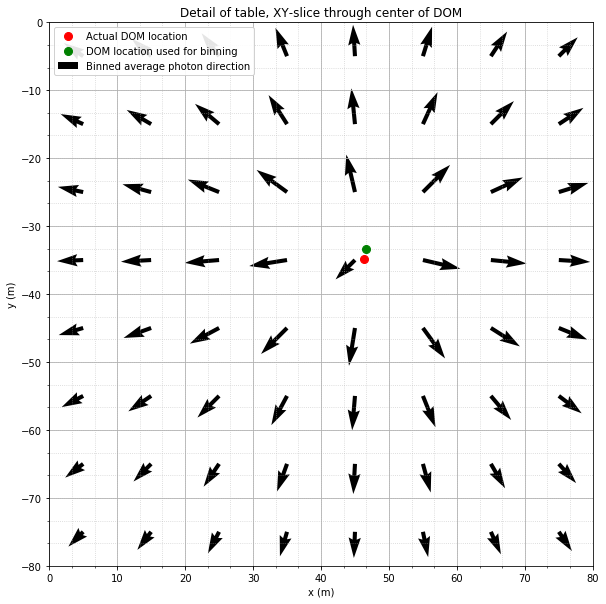

In [34]:
# Number of macro cells to look at in any direction from the dom
# (this will include any subcells due to oversampling)
ncells = 4

# Formulate a slice through the table to look at
slx = slice(dom_x_idx - ncells,
            dom_x_idx + ncells,
            1)
sly = slice(dom_y_idx - ncells,
            dom_y_idx + ncells,
            1)
slz = dom_z_idx
sl = (slx, sly, slz)

# Slice the x and y directions
pxsl = binned_px[sl]
pysl = binned_py[sl]

xmid = (xlims[0] + x_bw/2.0 + x_bw * np.arange(nx))[slx]
ymid = (ylims[0] + y_bw/2.0 + y_bw * np.arange(ny))[sly]
zmid = zlims[0] + z_bw/2.0 + z_bw * dom_z_idx

x_inner_lim = (xmid.min() - x_bw/2.0, xmid.max() + x_bw/2.0)
y_inner_lim = (ymid.min() - y_bw/2.0, ymid.max() + y_bw/2.0)
X, Y = np.meshgrid(xmid, ymid, indexing='ij')

fig = plt.figure(1, figsize=(10, 10), dpi=72)
fig.clf()
ax = fig.add_subplot(111)

ax.plot(
    dom_x, dom_y,
    'ro', ms=8, lw=0.5,
    label='Actual DOM location'
)
ax.plot(
    xlims[0] + x_os_bw*dom_x_os_idx,
    ylims[0] + y_os_bw*dom_y_os_idx,
    'go', ms=8, lw=0.5,
    label='DOM location used for binning'
)
ax.quiver(
    X, Y, pxsl, pysl,
    label='Binned average photon direction'
)

ax.axis('image')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

ax.set_xticks(np.arange(xlims[0], xlims[1]+x_bw, x_bw), minor=False)
ax.grid(which='major', b=True)
if x_oversample > 1:
    ax.set_xticks(
        np.arange(x_inner_lim[0]+x_os_bw, x_inner_lim[1], x_os_bw),
        minor=True
    )
    ax.grid(which='minor', b=True, ls=':', alpha=0.6)
    
if y_oversample > 1:
    ax.set_yticks(
        np.arange(y_inner_lim[0]+y_os_bw, y_inner_lim[1], y_os_bw),
        minor=True
    )
    ax.grid(which='minor', b=True, ls=':', alpha=0.6)
    
ax.set_xlim(x_inner_lim)
ax.set_ylim(y_inner_lim)
ax.legend(loc='upper left', fancybox=True, framealpha=0.9)
ax.set_title('Detail of table, XY-slice through center of DOM')
fig.savefig('xyslice_detail.png', dpi=300)
fig.savefig('xyslice_detail.pdf')
pass

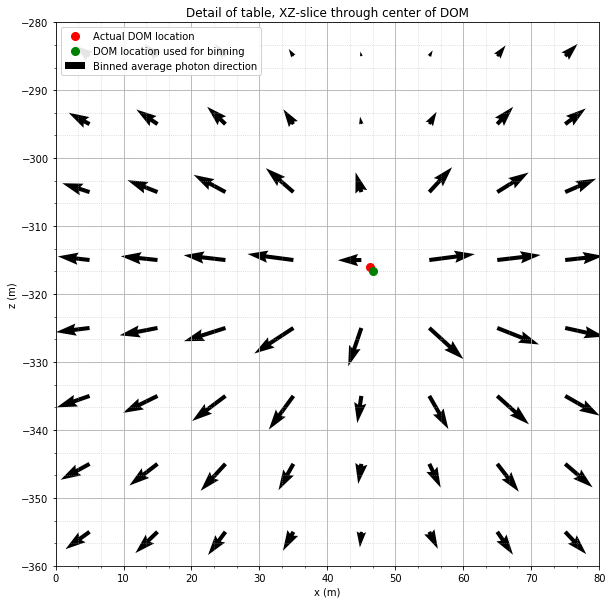

In [35]:
# Formulate a slice through the table to look at
slx = slice(dom_x_idx - ncells, dom_x_idx + ncells, 1)
sly = dom_y_idx
slz = slice(dom_z_idx - ncells, dom_z_idx + ncells, 1)
sl = (slx, sly, slz)

# Slice the x and y directions
pxsl = binned_px[sl]
pzsl = binned_pz[sl]

xmid = (xlims[0] + x_bw/2.0 + x_bw * np.arange(nx))[slx]
ymid = ylims[0] + y_bw/2.0 + y_bw * dom_y_idx
zmid = (zlims[0] + z_bw/2.0 + z_bw * np.arange(nz))[slz]

x_inner_lim = (xmid.min() - x_bw/2.0, xmid.max() + x_bw/2.0)
z_inner_lim = (zmid.min() - z_bw/2.0, zmid.max() + z_bw/2.0)
X, Z = np.meshgrid(xmid, zmid, indexing='ij')

fig = plt.figure(1, figsize=(10, 10), dpi=72)
fig.clf()
ax = fig.add_subplot(111)

ax.plot(
    dom_x, dom_z,
    'ro', ms=8, lw=0.5,
    label='Actual DOM location'
)
ax.plot(
    xlims[0] + x_os_bw*dom_x_os_idx,
    zlims[0] + z_os_bw*dom_z_os_idx,
    'go', ms=8, lw=0.5,
    label='DOM location used for binning'
)
ax.quiver(
    X, Z, pxsl, pzsl,
    label='Binned average photon direction'
)

ax.axis('image')
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')

ax.set_xticks(np.arange(xlims[0], xlims[1]+x_bw, x_bw), minor=False)
ax.grid(which='major', b=True)
if x_oversample > 1:
    ax.set_xticks(
        np.arange(x_inner_lim[0]+x_os_bw, x_inner_lim[1], x_os_bw),
        minor=True
    )
    ax.grid(which='minor', b=True, ls=':', alpha=0.6)
    
if z_oversample > 1:
    ax.set_yticks(
        np.arange(z_inner_lim[0]+z_os_bw, z_inner_lim[1], z_os_bw),
        minor=True
    )
    ax.grid(which='minor', b=True, ls=':', alpha=0.6)
    
ax.set_xlim(x_inner_lim)
ax.set_ylim(z_inner_lim)
ax.legend(loc='upper left', fancybox=True, framealpha=0.9)
ax.set_title('Detail of table, XZ-slice through center of DOM')
fig.savefig('xzslice_detail.png', dpi=300)
fig.savefig('xzslice_detail.pdf')
pass

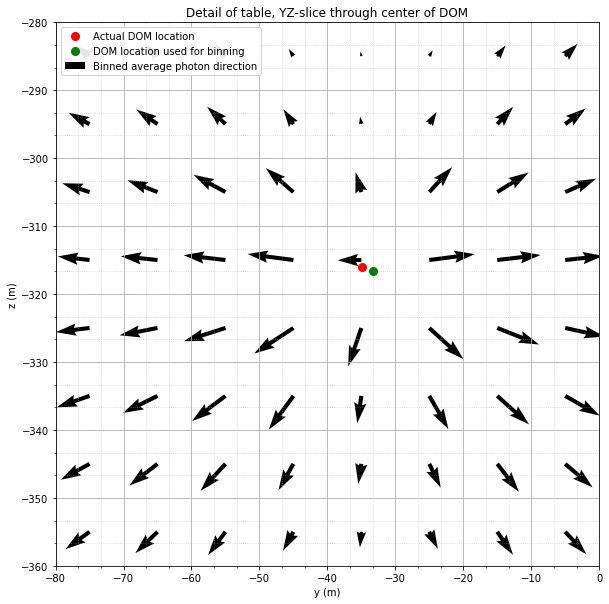

In [36]:
# Formulate a slice through the table to look at
slx = dom_x_idx
sly = slice(dom_y_idx - ncells, dom_y_idx + ncells, 1)
slz = slice(dom_z_idx - ncells, dom_z_idx + ncells, 1)
sl = (slx, sly, slz)

# Slice the x and y directions
pysl = binned_py[sl]
pzsl = binned_pz[sl]

xmid = xlims[0] + x_bw/2.0 + x_bw * dom_x_idx
ymid = (ylims[0] + y_bw/2.0 + y_bw * np.arange(ny))[sly]
zmid = (zlims[0] + z_bw/2.0 + z_bw * np.arange(nz))[slz]

y_inner_lim = (ymid.min() - y_bw/2.0, ymid.max() + y_bw/2.0)
z_inner_lim = (zmid.min() - z_bw/2.0, zmid.max() + z_bw/2.0)
Y, Z = np.meshgrid(ymid, zmid, indexing='ij')

fig = plt.figure(1, figsize=(10, 10), dpi=72)
fig.clf()
ax = fig.add_subplot(111)

ax.plot(
    dom_y, dom_z,
    'ro', ms=8, lw=0.5,
    label='Actual DOM location'
)
ax.plot(
    ylims[0] + y_os_bw*dom_y_os_idx,
    zlims[0] + z_os_bw*dom_z_os_idx,
    'go', ms=8, lw=0.5,
    label='DOM location used for binning'
)
ax.quiver(
    Y, Z, pysl, pzsl,
    label='Binned average photon direction'
)

ax.axis('image')
ax.set_xlabel('y (m)')
ax.set_ylabel('z (m)')

ax.set_xticks(np.arange(ylims[0], ylims[1]+y_bw, y_bw), minor=False)
ax.grid(which='major', b=True)
if y_oversample > 1:
    ax.set_xticks(
        np.arange(y_inner_lim[0]+y_os_bw, y_inner_lim[1], y_os_bw),
        minor=True
    )
    ax.grid(which='minor', b=True, ls=':', alpha=0.6)
    
if z_oversample > 1:
    ax.set_yticks(
        np.arange(z_inner_lim[0]+z_os_bw, z_inner_lim[1], z_os_bw),
        minor=True
    )
    ax.grid(which='minor', b=True, ls=':', alpha=0.6)
    
ax.set_xlim(y_inner_lim)
ax.set_ylim(z_inner_lim)
ax.legend(loc='upper left', fancybox=True, framealpha=0.9)
ax.set_title('Detail of table, YZ-slice through center of DOM')
fig.savefig('yzslice_detail.png', dpi=300)
fig.savefig('yzslice_detail.pdf')
pass

In [ ]:
fig = plt.figure(1, figsize=(10, 10), dpi=120)
fig.clf()

ax1 = fig.add_subplot(221)
pc1 = ax1.pcolormesh(
    binned_sp[x_center_idx, :, :].T,
    cmap='viridis', shading='flat',
    #vmin=vmin, vmax=vmax
)

ax2 = fig.add_subplot(222, sharey=ax1)
pc2 = ax2.pcolormesh(
    binned_sp[:, y_center_idx, :].T,
    cmap='viridis', shading='flat',
    #vmin=vmin, vmax=vmax
)

ax3 = fig.add_subplot(223, sharex=ax1)
pc3 = ax3.pcolormesh(
    binned_sp[:, :, z_center_idx],
    cmap='viridis', shading='flat',
    #vmin=vmin, vmax=vmax
)

ax4 = fig.add_subplot(224)
removeBorder(ax4, left=False, bottom=False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])

for pc in [pc3, pc2, pc1]:
    plt.colorbar(pc)
    
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
fig.suptitle('Survival probability planar slices through DOM')
fig.tight_layout(rect=(0, 0, 1, 0.98))
fig.savefig(join(tables_dir, 'slices.png'))
pass

In [ ]:
#mid_x = int(nx/2-1)
#mid_y = int(ny/2-1)
#mid_z = int(nz/2-1)

x_center_idx = dom_x_idx
y_center_idx = dom_y_idx
z_center_idx = dom_z_idx

#vmin, vmax = binned_sp.min(), binned_sp.max()

fig = plt.figure(1, figsize=(10, 10), dpi=600)
fig.clf()

ax1 = fig.add_subplot(221)
pc1 = ax1.pcolormesh(
    binned_sp[x_center_idx, :, :].T,
    cmap='viridis', shading='flat',
    #vmin=vmin, vmax=vmax
)

ax2 = fig.add_subplot(222, sharey=ax1)
pc2 = ax2.pcolormesh(
    binned_sp[:, y_center_idx, :].T,
    cmap='viridis', shading='flat',
    #vmin=vmin, vmax=vmax
)

ax3 = fig.add_subplot(223, sharex=ax1)
pc3 = ax3.pcolormesh(
    binned_sp[:, :, z_center_idx],
    cmap='viridis', shading='flat',
    #vmin=vmin, vmax=vmax
)

ax4 = fig.add_subplot(224)
removeBorder(ax4, left=False, bottom=False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])

for pc in [pc3, pc2, pc1]:
    plt.colorbar(pc)
    
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
fig.suptitle('Survival probability planar slices through DOM')
fig.tight_layout(rect=(0, 0, 1, 0.98))
fig.savefig(join(tables_dir, 'slices.png'))
pass